## A Preliminary analysis of the geograhpical distribution of US banks in 2019

### Understanding and Prepossessing the data: 1. ER Diagram and the HCR-INST-BR ternary relationship


This analysis aims to assess the geographic pattern of bank branch distribution using the Summary of Deposit (SoD) data. The data is readily available in [this SoD link](https://www7.fdic.gov/sod/sodDownload3.asp?sState=all&sInfoAsOf=2019&submit1=Continue&barItem=6). The SoD link also contains another table with detailed defintions of each variable within the SoD data. To start, we download the 2019 SoD (sod_2019, hereafter) for further analysis.

In [100]:
import os
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image

In [101]:
# Set the working directory
os.chdir('C:\\Users\\jiash\\Dropbox\\hw\\git\\bank_geo\\data')

# Read the data and the metadata file
sod_2019 = pd.read_csv('ALL_2019.csv', encoding = "ISO-8859-1") # the data file
sod_dfn = pd.read_csv('sod_variables_definitions.csv', encoding = "ISO-8859-1") # the meta file

The metadata sod_dfn also breaks down the variables into three categories: HCR, INST and BR. 
HCR (Horizontal Capital Review) is a type of regulatory documents required to be filed by "Large and Noncomplex Firms". More details of the HCR can be found from a brief description from Fed in [here](https://www.federalreserve.gov/publications/2019-may-supervision-and-regulation-report-supervisory-developments.htm). Thus, HCR in later analysis can be interpreted as large BHCs (bank holding companies). Although not yet found, other two acronyms (INST, BR) are very likely referring to banking institutions and bank branches.Below, we make sure that the metadata file contains all variables in sod_2019.

In [102]:
# Clean all variable names in sod_dfn doc
sod_dfn['NAME'] = sod_dfn['NAME'].str.upper() # Uppercase convertion
# add the underscore to date 
sod_dfn['NAME'] = sod_dfn['NAME'].str.replace(' DATE', '_DATE')
# correct the typo
sod_dfn['NAME'] = sod_dfn['NAME'].str.replace('LATITITUDE', 'LATITUDE') 
sod_dfn['NAME'] = sod_dfn['NAME'].str.replace(' ', '') # remove empty space

# Make sure all the variable names included in sod_fn
print('1. All variables  available in the metadata file? ')
any([i in list(sod_dfn['NAME']) for i in sod_2019.columns])

1. All variables  available in the metadata file? 


True

We notice that the table of SoD2019 can be organized as below ER diagrams:

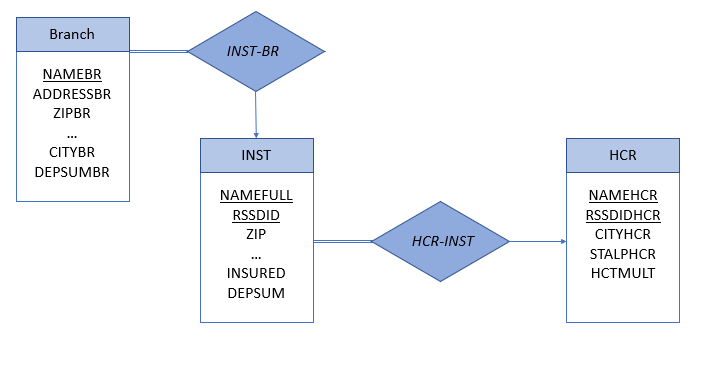

In [103]:
Image(filename='C:/Users/jiash/Dropbox/hw/git/bank_geo/ERD.png')

Accordingly, sod_2019 is segmented into three separate entites and one ternary relationship (we combine the INST-BR and HCR-INST) into one relationship. As a high leval summarization of the data, we start by accessing the ternary relationship HCR-INST-BR.


### The HCR-INST-BR ternary relationshipship

In [104]:
# Applying the unique command, the row# reduces from 86,367 to 84,900
# Also note that some of the NAMEHCR is empty since those institutions have no HCR
# But we have no empty values from NAMEFULL, meaning that all branches are associated with an INST

ternary = sod_2019[['NAMEHCR', 'NAMEFULL', 'NAMEBR']].drop_duplicates()
no_empty_hcr = ternary[ternary['NAMEHCR'].notnull()]
empty_hcr = ternary[ternary['NAMEHCR'].isnull()][['NAMEFULL', 'NAMEBR']]

num_br_hcr = no_empty_hcr[['NAMEHCR', 'NAMEBR']].groupby('NAMEHCR').count()
num_br_hcr.columns = ['num_br']

num_br_ins = empty_hcr[['NAMEFULL', 'NAMEBR']].groupby('NAMEFULL').count()
num_br_ins.columns = ['num_br']

We find that some institutions have no associated HCRs. With that, we divide branches with/without a valid HCR. In later analysis, we refer to these group as HCR/noHCR group.

In [105]:
# sum/mean of branches by group
# the dataset summ is prepared for a bar/pie/error bar chart
barchart = pd.DataFrame({'cls': ['with_HCR', 'wout_HCR'], 
                        'sum_BR': [num_br_hcr['num_br'].sum(), num_br_ins['num_br'].sum()], 
                        'ave_BR': [num_br_hcr['num_br'].mean(), num_br_ins['num_br'].mean()], 
                        'std_BR': [num_br_hcr['num_br'].std(), num_br_ins['num_br'].std()]})
barchart['perc_BR'] = barchart['sum_BR']/barchart['sum_BR'].sum() * 100
barchart[['ave_BR', 'std_BR', 'perc_BR']] = round(barchart[['ave_BR', 'std_BR', 'perc_BR']], 2)

# below dataset is prepared to generate the box plot
li = ['with_HCR'] * num_br_hcr.shape[0]
li.extend(['wout_HCR'] * num_br_ins.shape[0])

li1 = list(num_br_hcr['num_br'])
li1.extend(list(num_br_ins['num_br']))

box = pd.DataFrame({'cls':li, 'num_br':li1})

fig = make_subplots(rows = 2, cols = 2, specs=[[{"type": "bar"}, {"type": "pie"}], [{"type": "box"}, {"type": "bar"}]],
                   subplot_titles=("Fig 1.1. Total number BR", "Fig 1.2. Distribution of total number BR",
                                   "Fig 1.3. Box plot of the number BR", "Fig 1.4. Error bar average BR num"))

fig.add_trace(go.Bar(x = barchart['cls'], y = barchart['sum_BR'], text = barchart['sum_BR'],textposition = 'auto'), 1, 1)
fig.add_trace(go.Pie(labels = list(barchart['cls']), values = list(barchart['perc_BR']), textposition='inside'), 1, 2)
fig.add_trace(go.Box(y = box['num_br'], x = box['cls']), 2, 1)
fig.add_trace(go.Bar(x = barchart['cls'], y = barchart['ave_BR'], error_y=dict(type='data', array=barchart['std_BR'])), 2, 2)

fig.show()

The total branch number of HCR and noHCR are 80102 and 4798, which takes 94.4 and 5.6 percent of the total bank branches in US. The average among these two groups are 20.98 and 5.03. From fig 1.1 and 1.2, it's straightforward that banks organized by HCR hold majority of bank branches in US. From fig 1.3 and 1.4, we find that within the HCR group, the average is dominated by several of the outlier, or big HCR BHCs that potentially hold vast numbers of branches. Below we find the top 10 banks with most branches and visualize a selected list of HCR BHCs in a wordcloud.

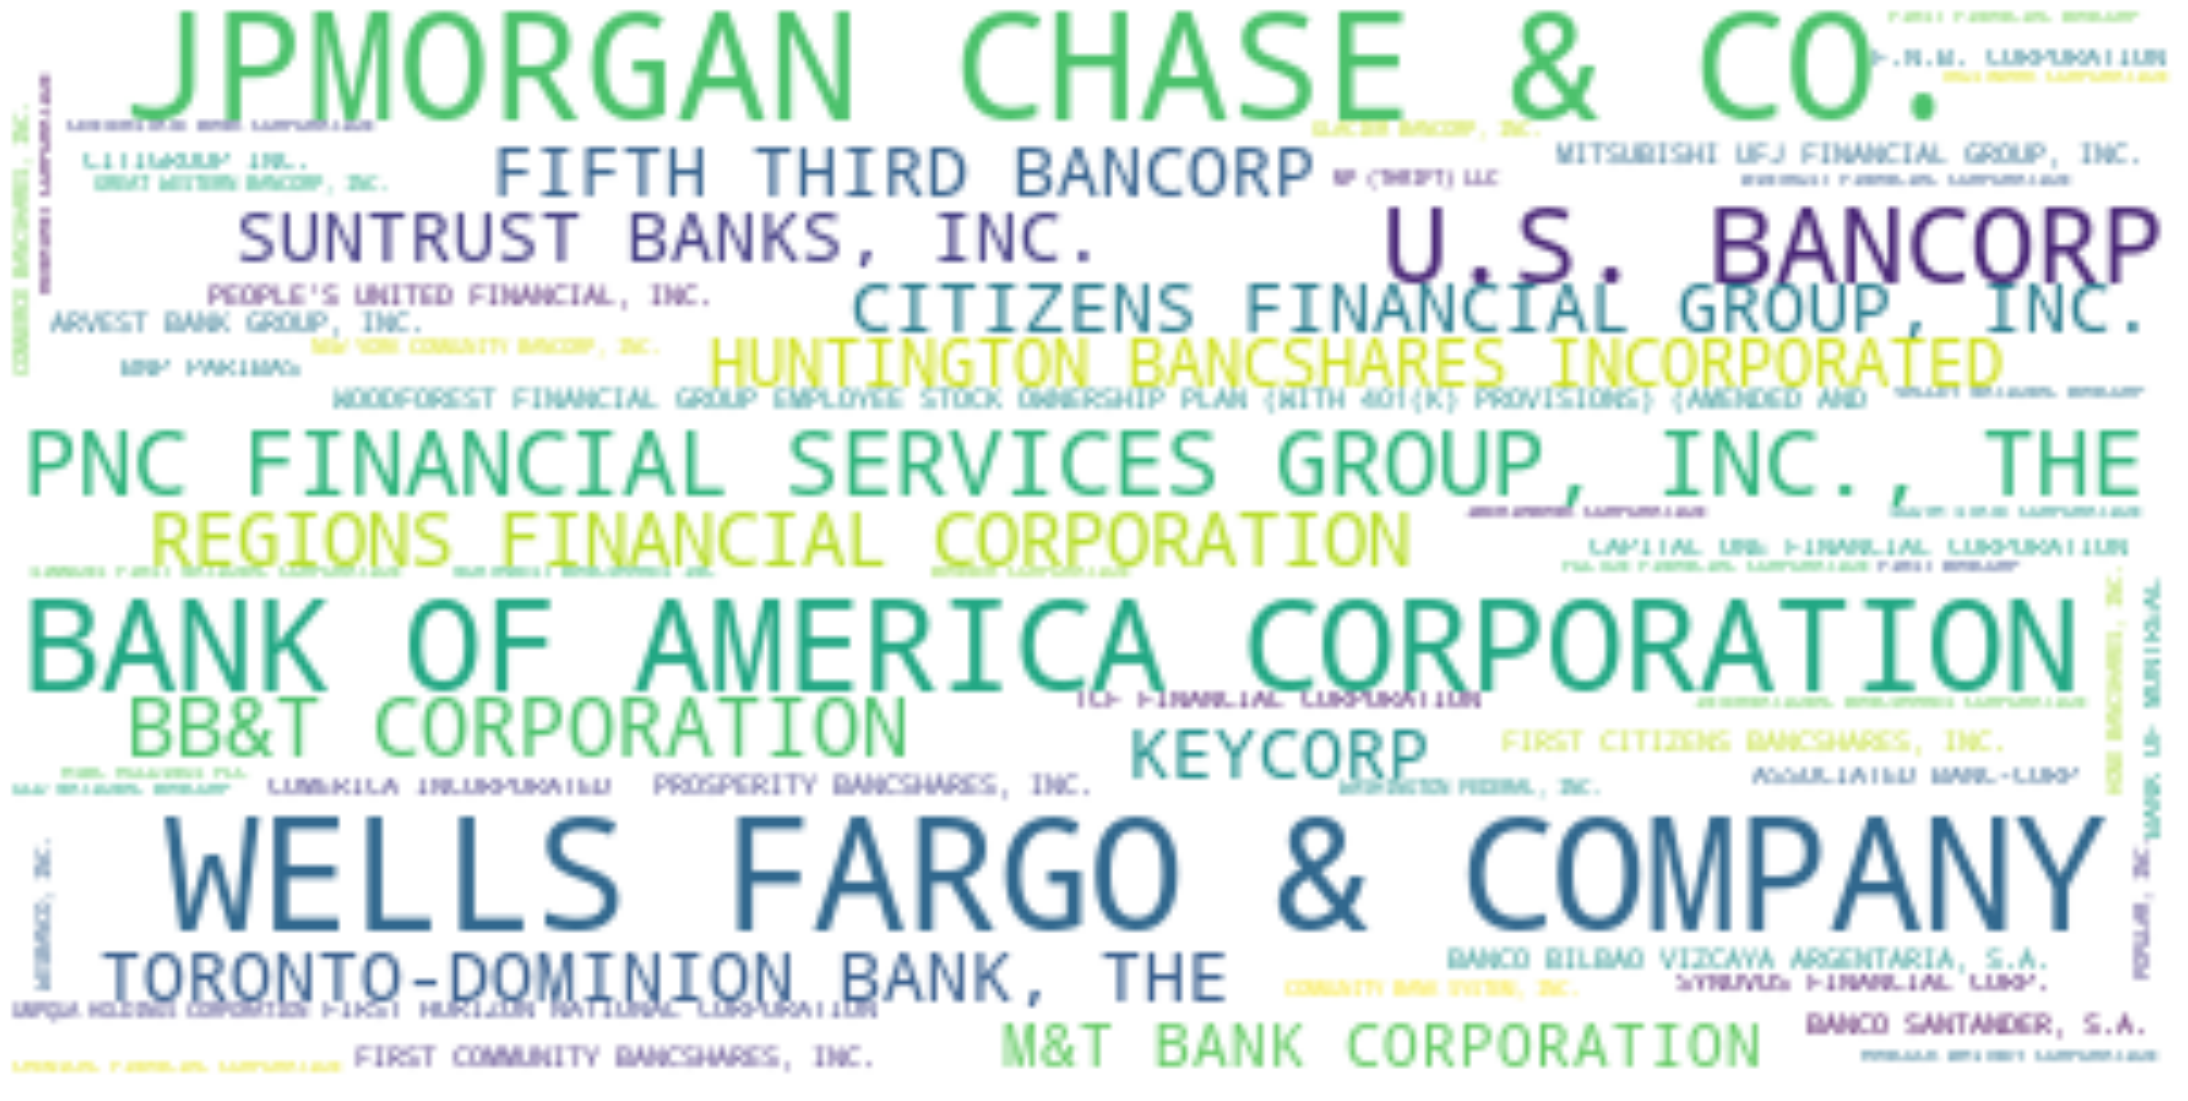

In [106]:
# keep hcr over threshold
top_hrc = num_br_hcr[num_br_hcr['num_br'] >= 100]
d = {}

for i in range(len(top_hrc)):
    d[top_hrc.index[i]] = top_hrc['num_br'][i]

# generate teh word cloud
wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies = d)
plt.figure(figsize=(40,20))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

It has also occured to me that the ternary relationship can be represented by a tree. As another exercise, I create a tree of the DEUTSCHE BANK.

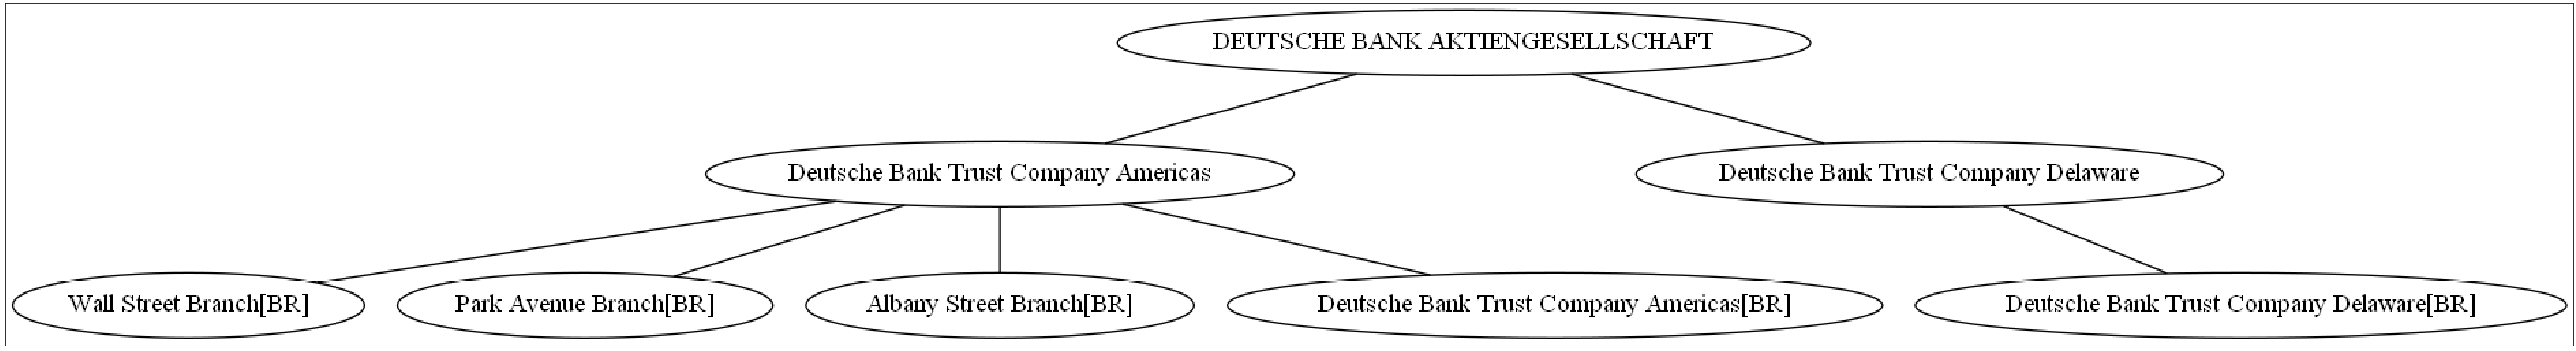

In [107]:
# I use DEUTSCHE BANK AKTIENGESELLSCHAFT as an example
db = ternary[ternary['NAMEHCR'] == 'DEUTSCHE BANK AKTIENGESELLSCHAFT']

# I notice that some of the branch share the same name as their parent institute
db.NAMEBR = db.NAMEBR.map(str) + '[BR]'

# initialize the graph
graph = pydot.Dot(graph_type = 'graph')

# edge1 is the edge between HCR and institute
for i in db.NAMEFULL.unique():
    edge1 = pydot.Edge(db.iloc[0, 0], i)
    graph.add_edge(edge1)

# edge2 is the edge between parent institute and branches
for i in range(db.shape[0]): 
    edge2 = pydot.Edge(db.iloc[i, 1], db.iloc[i, 2])
    graph.add_edge(edge2)
    
graph.write_png('example1_graph.png')
img = mpimg.imread('example1_graph.png')
plt.figure(figsize=(100,40))
plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

The next part would focus on prepossessing and understanding the three entities highlighted in the ERD.

In [108]:
# variable names associated with three different entities
hcr_names = list(sod_dfn[sod_dfn['BRANCH   INSTITUTION  HOLDING CO'] == 'HCR']['NAME'])
ins_names = list(sod_dfn[sod_dfn['BRANCH   INSTITUTION  HOLDING CO'] == 'INST']['NAME'])
brh_names = list(sod_dfn[sod_dfn['BRANCH   INSTITUTION  HOLDING CO'] == 'BR']['NAME'])

# keep those variables and delete duplicates
hcr_raw = sod_2019[hcr_names].drop_duplicates()
ins_raw = sod_2019[ins_names].drop_duplicates()
brh_raw = sod_2019[brh_names].drop_duplicates()

# Set the working directory
os.chdir('C:\\Users\\jiash\\Dropbox\\hw\\git\\bank_geo\\data')
# save the raw data for next step analysis
hcr_raw.to_csv('hcr_raw.csv')
ins_raw.to_csv('ins_raw.csv')
brh_raw.to_csv('brh_raw.csv')